In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import sklearn

In [2]:
#Define classes from nn.Module (easy to work with when taking gradients).Note that in the simplest case of Woodford
# encoder and decoder are not strictly necessary, as they are both determined by the same parameters.
class CategoricalEncoder(torch.nn.Module):
    def __init__(self,mu0,sigma0,q0):
        super().__init__()
        self.a = torch.nn.Parameter(-1/(2*sigma0**2))
        self.b = torch.nn.Parameter(mu0/sigma0**2)
        self.c = torch.nn.Parameter(-mu0**2/(2*sigma0**2) -torch.log(sigma0) - torch.log(F.softmax(q0)))
    def forward(self,x):
        # x has shape [batch_dim,x_dim], a,b,c has shape [x_dim, N]
        p_tilde = (x**2)@(self.a) + x@(self.b) + self.c
        return p_tilde#F.softmax(p_tilde,dim=1)

class GaussianDecoder(torch.nn.Module):
    def __init__(self,mu0,sigma0,q0):
        super().__init__()
        self.q  = torch.nn.Parameter(F.softmax(q0))
        self.mu = torch.nn.Parameter(mu0.transpose(0,1))
        self.logsigma = torch.nn.Parameter(torch.log(sigma0.transpose(0,1)))
    def forward(self,r):
        return (r)@(self.mu),(r)@(self.sigma)

In [3]:
 #Sum of losses in the most general case -- to fix
 def distortion(x_data,encoder,decoder):
    #Compute p(j|x) as a bs x N matrix
    p_j_x = F.softmax(encoder(x_data))
    #Compute log(q(x|j))
    inv_sigma2 = 1/torch.exp(2*(decoder.logsigma.transpose(0,1)))
    mp = (decoder.mu.transpose(0,1)*inv_sigma2)
    logq_x_j = -0.5*(x_data**2)@inv_sigma2 + (x_data@mp) - 0.5*(mp)*(decoder.mu.transpose(0,1)) - np.log(np.sqrt(2*np.pi))-decoder.logsigma.transpose(0,1)
    # E_x[ sum_j p(j|x)*log(q(x|j))]
    loss = -((p_j_x*logq_x_j).sum(dim=1)).mean()
    return loss
def rate(x_data,encoder,decoder):
    p_tilde = encoder(x_data)
    dkl = (F.softmax(p_tilde)*(F.log_softmax(p_tilde) - F.log_softmax(decoder.q))).sum(dim=1).mean()
    return dkl

In [64]:
N = 20
BATCH_SIZE = 50
mu0 = torch.arange(0,20,20/N)[None,:]
sigma0 = torch.ones(N)[None,:]
q0 = 1/N*torch.ones(N)[None,:]
#Define data distribution
x_data = torch.distributions.exponential.Exponential(0.5).sample((500,))[:,None]
x_sorted,indices = x_data.sort(dim=0)
x_loader = torch.utils.data.DataLoader(x_data,BATCH_SIZE)
encoder = CategoricalEncoder(mu0,sigma0,q0)
decoder = GaussianDecoder(mu0,sigma0,q0)
#Define optimizer and parameters to iterate on
params = list(encoder.parameters()) + list(decoder.parameters())
optimizer = torch.optim.SGD(params,0.001)

<ipython-input-2-9fa6aad5f02a>:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  self.c = torch.nn.Parameter(-mu0**2/(2*sigma0**2) -torch.log(sigma0) - torch.log(F.softmax(q0)))
<ipython-input-2-9fa6aad5f02a>:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  self.q  = torch.nn.Parameter(F.softmax(q0))


In [84]:
history_loss = []
for epoch in range(500):
    for x_s in x_loader:
        loss =  rate(x_s,encoder,decoder) + distortion(x_data,encoder,decoder)
        history_loss.append(loss.item()) 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

<ipython-input-3-65cfbd63e13d>:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  dkl = (F.softmax(p_tilde)*(F.log_softmax(p_tilde) - F.log_softmax(decoder.q))).sum(dim=1).mean()
<ipython-input-3-65cfbd63e13d>:14: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  dkl = (F.softmax(p_tilde)*(F.log_softmax(p_tilde) - F.log_softmax(decoder.q))).sum(dim=1).mean()
<ipython-input-3-65cfbd63e13d>:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  p_j_x = F.softmax(encoder(x_data))


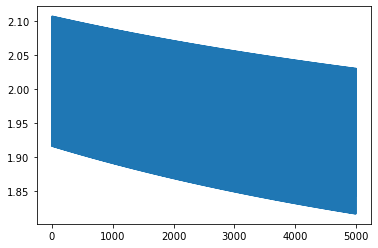

In [85]:
with torch.no_grad():
    plt.plot(history_loss)

In [32]:
encoder_opt = CategoricalEncoder(decoder.mu.transpose(0,1),torch.exp(decoder.logsigma).transpose(0,1),decoder.q)
p_j_x = F.softmax(encoder(x_sorted))
p_j_x_opt = F.softmax(encoder_opt(x_sorted))

<ipython-input-2-9fa6aad5f02a>:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  self.c = torch.nn.Parameter(-mu0**2/(2*sigma0**2) -torch.log(sigma0) - torch.log(F.softmax(q0)))
<ipython-input-32-9c2488f5850e>:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  p_j_x = F.softmax(encoder(x_sorted))
<ipython-input-32-9c2488f5850e>:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  p_j_x_opt = F.softmax(encoder_opt(x_sorted))


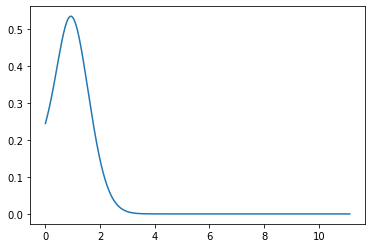

In [39]:
with torch.no_grad():
    plt.plot(x_sorted,p_j_x[:,1])

tensor([[0.2967],
        [0.5548],
        [0.8369],
        [1.1334],
        [1.1470],
        [1.0642],
        [1.0881],
        [1.0392],
        [0.9502],
        [0.9996],
        [1.0951],
        [0.9940],
        [1.0127],
        [1.0668],
        [1.0073],
        [1.0001],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000]], grad_fn=<ExpBackward>)

In [49]:
x_loader[1]

TypeError: 'DataLoader' object is not subscriptable